# Install/import data

In [ ]:
# libraries
!pip install pymssql
import pymssql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import imblearn
from imblearn.over_sampling import SMOTE

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance as plot_importance_xgb
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier, plot_importance as plot_importance_lgbm

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from yellowbrick.classifier import ConfusionMatrix

# Data connection/ understanding

In [ ]:
# Server: 45.117.83.230 - Port : 1433
# - Account : Student_DA_Q1 - Table: [dbo].[Customer_Churn_Banker]
# - Password: @MindXDream2023

server = '45.117.83.230'
port = 1433
account = 'Student_DA_Q1'
password = '@MindXDream2023'
db = 'DA_FINAL_TEST'

connection = pymssql.connect(host = server, port = port, user = account, password = password, database = db)
query = 'SELECT * FROM [dbo].[Customer_Churn_Banker]'

# Gán kết quả query vào dataframe
df = pd.read_sql(query, connection)

df

<ipython-input-2-d358c8aa9aaa>:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  object 
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


In [ ]:
df.shape

(10000, 12)

In [ ]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,199992.480000,1.000000


In [ ]:
df.describe(exclude = ['int64', 'float64'])

,country,gender,credit_card
count,10000,10000,10000
unique,3,2,2
top,France,Male,1
freq,5014,5457,7055


# Data Preprocessing

In [ ]:
# ép kiểu dữ liệt của cột credit_card từ 'object' sang int
df['credit_card'] = df['credit_card'].astype('int64')

## Handle missing values and duplicated rows

In [ ]:
df.isnull().sum()

,0
customer_id,0
credit_score,0
country,0
gender,0
age,0
tenure,0
balance,0
products_number,0
credit_card,0
active_member,0


In [ ]:
df.duplicated().sum()

np.int64(0)

Nhận xét: không có giá trị bị thiếu, tất cả các hàng đều là duy nhất

## Exploratory data analysis

### Phân tích đơn biến

<ipython-input-10-36fe41becc71>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'gender', data = df, palette = 'Set2')
<ipython-input-10-36fe41becc71>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'country', data = df, palette = 'Set2')
<ipython-input-10-36fe41becc71>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'credit_card', data = df, palette = 'Set2')
<ipython-input-10-36fe41becc71>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` varia

<Axes: title={'center': 'Active_member'}, xlabel='active_member', ylabel='count'>

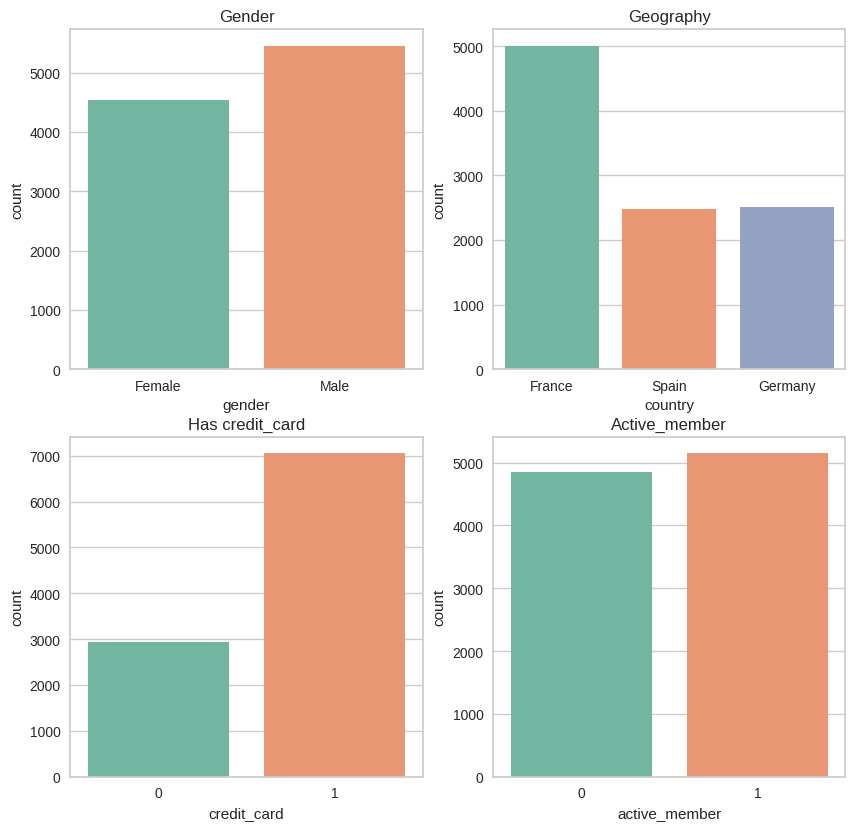

In [ ]:
# Các biến phân loại
plt.figure(figsize = (10,15))
# Theo giới tính
plt.subplot(3,2,1)
plt.gca().set_title('Gender')
sns.countplot(x = 'gender', data = df, palette = 'Set2')
# Theo quốc gia
plt.subplot(3,2,2)
plt.gca().set_title('Geography')
sns.countplot(x = 'country', data = df, palette = 'Set2')
# Số lượng khách hàng có thẻ tín dụng chưa?
plt.subplot(3,2,3)
plt.gca().set_title('Has credit_card')
sns.countplot(x = 'credit_card', data = df, palette = 'Set2')
# Số lượng thành viên tích cực của bạn
plt.subplot(3,2,4)
plt.gca().set_title('Active_member')
sns.countplot(x = 'active_member', data = df, palette = 'Set2')

Nhận xét:
* Khách hàng đến từ France chiếm 50% trong tổng số
* Số lượng khách hàng Nam nhiều hơn Nữ nhưng không chênh lệch nhiều
* 70% khách hàng có thẻ tín dụng
* Số lượng khách hàng sử dụng tích cực và không tích cực gần như ngang nhau


In [ ]:
df['churn'].value_counts(normalize = True)*100

,proportion
churn,
0,79.63
1,20.37


20% khách hàng này đã rời bỏ dịch vụ, phản ánh tỷ lệ rời bỏ tương đối thấp. Dữ liệu này cho thấy doanh nghiệp đang hoạt động tốt trong việc giữ chân khách hàng. Tuy nhiên, một tỷ lệ nhỏ khách hàng rời bỏ vẫn có thể được xem xét để cải thiện hiệu suất tổng thể.

<function matplotlib.pyplot.show(close=None, block=None)>

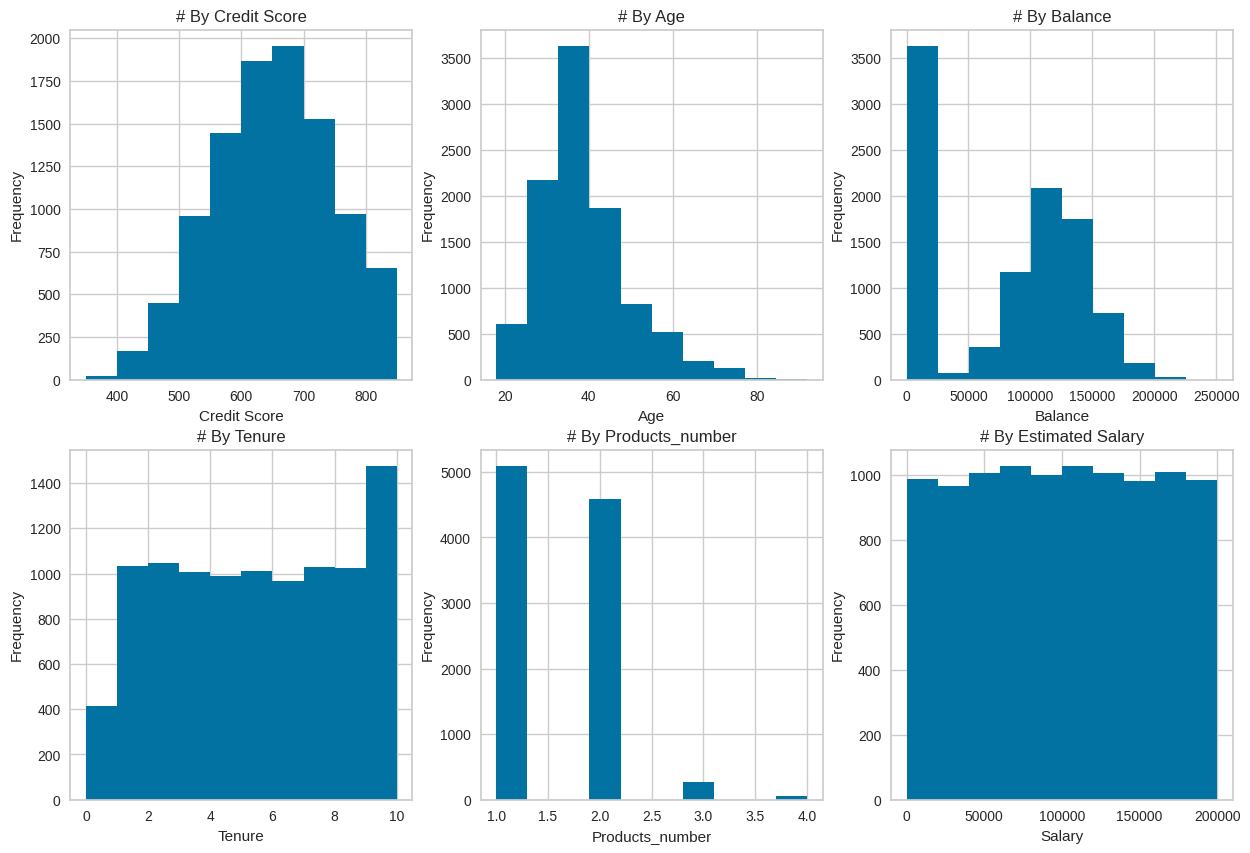

In [ ]:
# Các biến số
plt.figure(figsize = (15,10))
# histogram cho biến credit_score
plt.subplot(2,3,1)
plt.hist(df['credit_score'])
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.title('# By Credit Score')

# Age
plt.subplot(2,3,2)
plt.hist(df['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('# By Age')

# Balance
plt.subplot(2,3,3)
plt.hist(df['balance'])
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.title('# By Balance')

# Tenure
plt.subplot(2,3,4)
plt.hist(df['tenure'])
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.title('# By Tenure')

# Products number
plt.subplot(2,3,5)
plt.hist(df['products_number'])
plt.xlabel('Products_number')
plt.ylabel('Frequency')
plt.title('# By Products_number')

# Estimated Salary
plt.subplot(2,3,6)
plt.hist(df['estimated_salary'])
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('# By Estimated Salary')

plt.show

Điểm tín dụng tập trung chủ yếu ở khoảng 600-750. Điều này cho thấy hầu hết khách hàng có điểm tín dụng trung bình đến cao, ít khách hàng có điểm quá thấp hoặc quá cao.

Phần lớn khách hàng nằm trong độ tuổi 30-50. Có rất ít khách hàng dưới 20 hoặc trên 70 tuổi, cho thấy độ tuổi trung bình của khách hàng khá cao.

Balance (Số dư tài khoản): Dữ liệu bị lệch trái, với số lượng rất lớn khách hàng có số dư bằng 0, trong khi một nhóm nhỏ có số dư cao hơn -->  Điều này có thể phản ánh việc nhiều khách hàng bỏ hoang thẻ ngân hàng hoặc chỉ mở để nhận được khuyến mãi.

Tenure (Thời gian gắn bó với ngân hàng): Phân bố khá đồng đều, nhưng có sự tăng vọt ở giá trị 10 năm, có thể do chính sách ngân hàng hoặc đặc điểm của tập khách hàng lâu năm.

Phần lớn khách hàng sử dụng 1-2 sản phẩm. Rất ít khách hàng sử dụng 3 hoặc 4 sản phẩm -->  cho thấy cơ hội để ngân hàng có thể mở rộng dịch vụ cho khách hàng hiện tại.

Không có sự chênh lệch lớn về mức thu nhập giữa các khách hàng.

Nhận xét: Việc hiểu rõ những mô hình này giúp doanh nghiệp triển khai các chiến lược tiếp thị có mục tiêu, chẳng hạn như thúc đẩy việc bán chéo các sản phẩm tài chính, hay nhắm mục tiêu đến các nhóm khách hàng có số dư tài khoản thấp để gia tăng giá trị giao dịch.

In [ ]:
df['balance'].value_counts()

,count
balance,
0.00,3617
130170.82,2
105473.74,2
159397.75,1
144238.70,1
...,...
108698.96,1
238387.56,1
111833.47,1


In [ ]:
df.groupby('churn')['balance'].apply(lambda x: (x == 0.00).sum())

,balance
churn,
0,3117
1,500


Balance (Số dư tài khoản): Dữ liệu bị lệch trái, với số lượng rất lớn khách hàng có số dư bằng 0, trong khi một nhóm nhỏ có số dư cao hơn -->  Điều này có thể phản ánh việc nhiều khách hàng bỏ hoang thẻ ngân hàng hoặc chỉ mở để nhận được khuyến mãi. Cho nên chúng ta sẽ loại bỏ nhóm khách hàng có số dư bằng 0, đề xuất chiến lược riêng để họ sử dụng thẻ nhiều lần khác, và sẽ phân tích nhóm khách hàng khác để hiểu hành vi và dự đoán chính xác đối với những khách hàng đã sử dụng cho mục đích giao dịch chuyển đổi của họ

<Axes: >

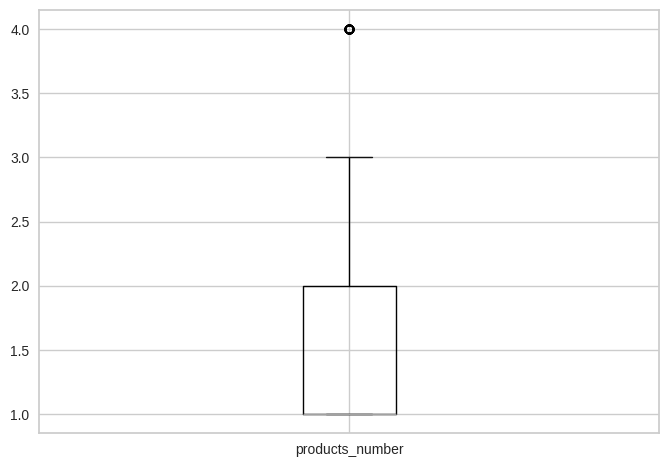

In [ ]:
df.boxplot(column=['products_number'])

### Phân tích hai biến

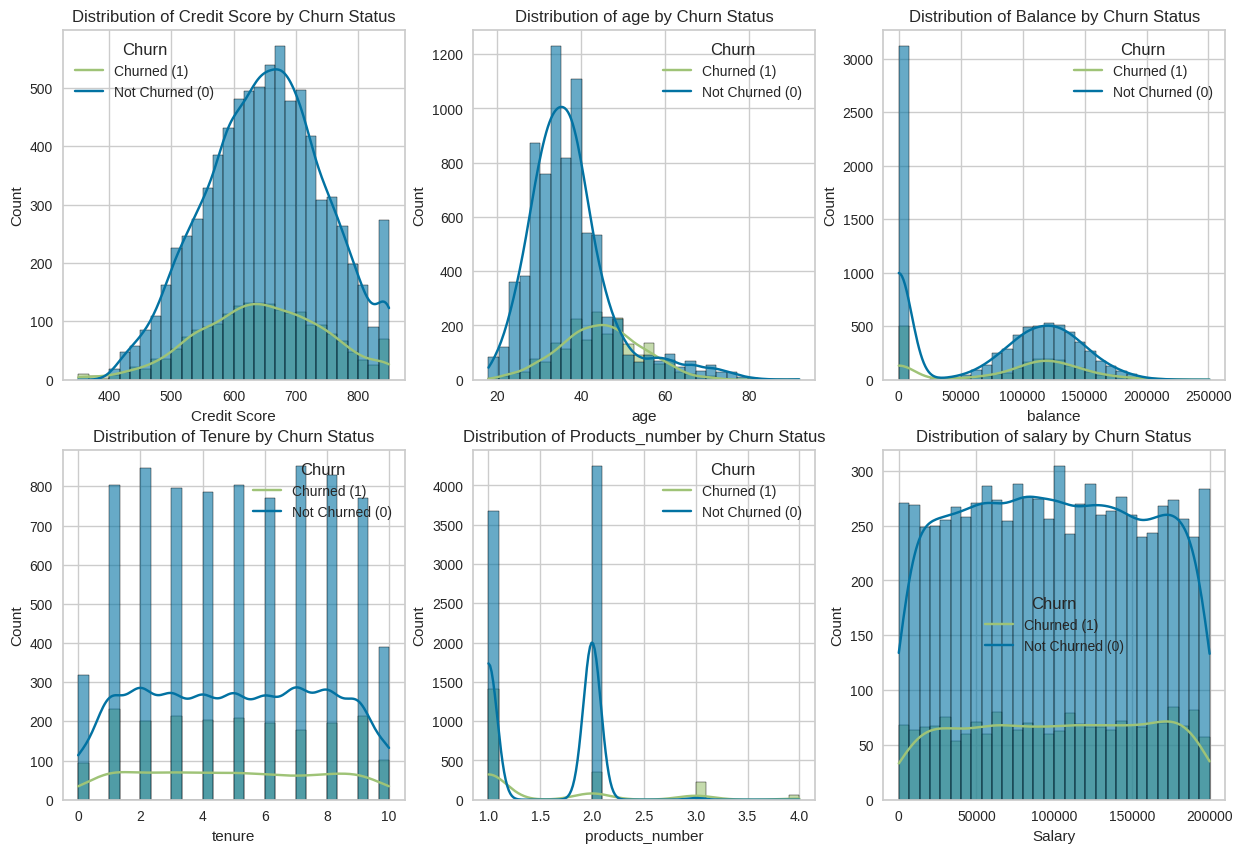

In [ ]:
plt.figure(figsize=(15,10))
# credit_score by churn
plt.subplot(2,3,1)
sns.histplot(data=df, x="credit_score", hue = 'churn', kde=True, bins=30, alpha=0.6)
plt.title("Distribution of Credit Score by Churn Status")
plt.xlabel("Credit Score")
plt.ylabel("Count")
plt.legend(title="Churn", labels=["Churned (1)", "Not Churned (0)"])
# age by churn
plt.subplot(2,3,2)
sns.histplot(data=df, x="age", hue="churn", kde=True, bins=30, alpha=0.6)
plt.title("Distribution of age by Churn Status")
plt.xlabel("age")
plt.ylabel("Count")
plt.legend(title="Churn", labels=["Churned (1)", "Not Churned (0)"])
# balance by churn
plt.subplot(2,3,3)
sns.histplot(data=df, x="balance", hue="churn", kde=True, bins=30, alpha=0.6)
plt.title("Distribution of Balance by Churn Status")
plt.xlabel("balance")
plt.ylabel("Count")
plt.legend(title="Churn", labels=["Churned (1)", "Not Churned (0)"])
# tenure by churn
plt.subplot(2,3,4)
sns.histplot(data=df, x="tenure", hue="churn", kde=True, bins=30, alpha=0.6)
plt.title("Distribution of Tenure by Churn Status")
plt.xlabel("tenure")
plt.ylabel("Count")
plt.legend(title="Churn", labels=["Churned (1)", "Not Churned (0)"])
# products number
plt.subplot(2,3,5)
sns.histplot(data=df, x="products_number", hue="churn", kde=True, bins=30, alpha=0.6)
plt.title("Distribution of Products_number by Churn Status")
plt.xlabel("products_number")
plt.ylabel("Count")
plt.legend(title="Churn", labels=["Churned (1)", "Not Churned (0)"])
# salary
plt.subplot(2,3,6)
sns.histplot(data=df, x="estimated_salary", hue="churn", kde=True, bins=30, alpha=0.6)
plt.title("Distribution of salary by Churn Status")
plt.xlabel("Salary")
plt.ylabel("Count")
plt.legend(title="Churn", labels=["Churned (1)", "Not Churned (0)"])

plt.show()

Khách hàng rời bỏ xuất hiện ít hơn ở mọi mức điểm tín dụng nhưng có sự phân bố rộng, chủ yếu tập trung trong độ tuổi 40-50, trong khi nhóm người ở lại rơi vào 30-40 tuổi => sự khác biệt.

Số dư tài khoản của họ cũng phân bố tương tự như nhóm không rời bỏ. Xét về thời gian gắn bó, họ xuất hiện ít hơn ở mọi mức tenure, chủ yếu trong khoảng 1-9 năm. Đa số chỉ sử dụng một sản phẩm.

Trong khi đó, mức lương không có sự khác biệt rõ rệt giữa hai nhóm, cho thấy đây không phải là yếu tố chính ảnh hưởng đến churn.




Phân tích đa biến

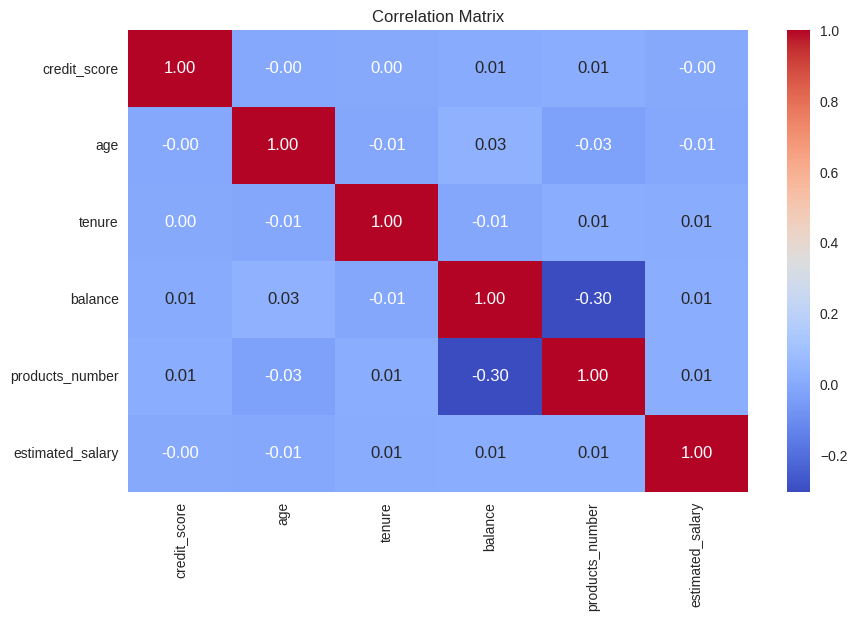

In [ ]:
numeric_columns = df[['credit_score','age', 'tenure', 'balance', 'products_number', 'estimated_salary']]
plt.figure(figsize=(10,6))
sns.heatmap(numeric_columns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

::Dữ liệu này không có các mối quan hệ mạnh giữa các biến ( không có hiện tượng đa cộng tuyến)

Khách hàng có Products_number = 3 và 4 có xu hướng rời bỏ nhiều hơn (chấm xanh nhạt nhiều hơn). Điều này có thể cho thấy rằng khách hàng sử dụng nhiều sản phẩm hơn có nguy cơ rời bỏ cao hơn.

# Feature Engineering

## Feature selection

In [ ]:
# Encode Country and Gender variable
# Onehot bằng get_dummies
df_country = pd.get_dummies(df['country'], dtype = 'int')
df_gender = pd.get_dummies(df['gender'], dtype = 'int')

In [ ]:
df = pd.concat([df, df_country, df_gender], axis = 1)
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,France,Germany,Spain,Female,Male
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [ ]:
df.drop(['country', 'gender', 'customer_id'], axis = 1, inplace = True)
df.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,France,Germany,Spain,Female,Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [ ]:
X = df.drop(['churn'], axis = 1)
y = df['churn']

## Train-test splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(X_test.shape)

(8000, 13)
(2000, 13)


## Handle Class Imbalance

In [ ]:
#oversampling dataset
oversample=SMOTE()
X_train_smote, y_train_smote=oversample.fit_resample(X_train,y_train)

#count y
Counter(y_train_smote)

Counter({0: 6356, 1: 6356})

# Model evaluation

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [ ]:
# Define the classifiers
classifiers = {
    'Gradient Boosting': GradientBoostingClassifier(random_state=10),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=10),
    'XGBoostClassifier': XGBClassifier(n_estimators=100),
    'LogisticRegression': LogisticRegression(max_iter = 1000),
    'Linear SVM': svm.SVC(kernel='linear')
}

In [ ]:
for name, clf in classifiers.items():
    clf.fit(X_train_smote, y_train_smote)
    y_pred = clf.predict(X_test)

    print(f'Classification report for {name}:')
    print(classification_report(y_test, y_pred))

Classification report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1607
           1       0.65      0.61      0.63       393

    accuracy                           0.86      2000
   macro avg       0.78      0.76      0.77      2000
weighted avg       0.85      0.86      0.86      2000

Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1607
           1       0.65      0.58      0.61       393

    accuracy                           0.86      2000
   macro avg       0.78      0.75      0.76      2000
weighted avg       0.85      0.86      0.85      2000

Classification report for XGBoostClassifier:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1607
           1       0.62      0.59      0.60       393

    accuracy                           0.85      20

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1607
           1       0.49      0.49      0.49       393

    accuracy                           0.80      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.80      0.80      0.80      2000



# Hyper parameter tuning (Optimization)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}
gb_model = GradientBoostingClassifier()
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_gb.fit(X_train_smote, y_train_smote)
# Get the best parameters and best model
best_params = grid_search_gb.best_params_
best_model = grid_search_gb.best_estimator_

# Make predictions on the test set using the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)

# Print the results
print(f'Best Parameters:', best_params)
print(f'Best Model Accuracy:', accuracy_best)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Best Model Accuracy: 0.8285043069694596


In [ ]:
param_grid_rf = {"max_depth": [2,3, None],
              "n_estimators":[50,100,200,300,400,500],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
rf_model = RandomForestClassifier()
grid_search_rf = GridSearchCV(estimator= rf_model,
                 param_grid = param_grid_rf,
                 scoring="accuracy",  #metrics
                 cv = 3,              #cross-validation
                 n_jobs = 1)
grid_search_rf.fit(X_train_smote, y_train_smote)
print(grid_search_rf.best_estimator_)

RandomForestClassifier(max_features=3, n_estimators=200)


In [ ]:
# Define the classifiers
new_classifiers = {
    'Gradient Boosting': GradientBoostingClassifier(learning_rate = 0.2, max_depth = 7, n_estimators = 200, random_state=10),
    'Random Forest': RandomForestClassifier(max_features = 3, n_estimators = 200, random_state=10)
}

In [ ]:
for name, clf in new_classifiers.items():
    clf.fit(X_train_smote, y_train_smote)
    y_pred = clf.predict(X_test)

    print(f'Classification report for {name}:')
    print(classification_report(y_test, y_pred))

Classification report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1607
           1       0.65      0.56      0.60       393

    accuracy                           0.85      2000
   macro avg       0.77      0.74      0.76      2000
weighted avg       0.85      0.85      0.85      2000

Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1607
           1       0.66      0.56      0.60       393

    accuracy                           0.86      2000
   macro avg       0.78      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000



                     Recall  F1 Score  Accuracy  Precision       AUC
Gradient Boosting  0.562341  0.602180     0.854   0.648094  0.839486
Random Forest      0.559796  0.604396     0.856   0.656716  0.852121


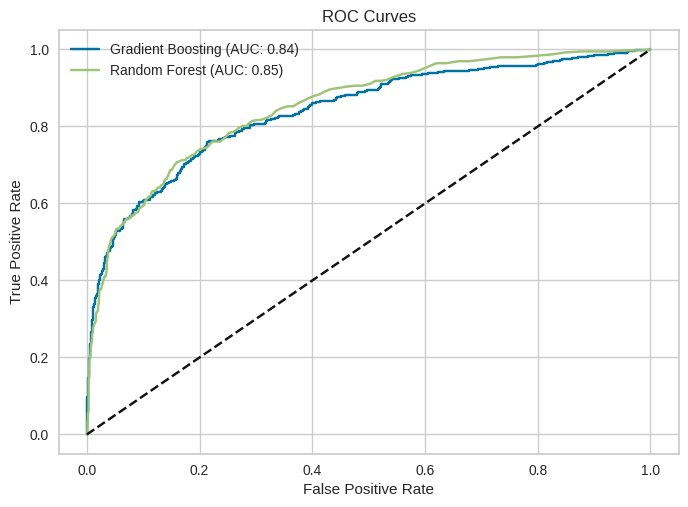

In [ ]:
# Train and evaluate each classifier
from sklearn.model_selection import cross_val_score
results = {}
for name, clf in new_classifiers.items():
    clf.fit(X_train_smote, y_train_smote)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    results[name] = {
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob)
    }

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC: {results[name]["AUC"]:.2f})')

# Display results
results_df = pd.DataFrame(results).transpose()
print(results_df)

# Plot configuration
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.show()

In [ ]:
for name, clf in new_classifiers.items():
    clf.fit(X_train_smote, y_train_smote)
    y_pred = clf.predict(X_test)

    print(f'Classification report for {name}:')
    print(classification_report(y_test, y_pred))

Classification report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1607
           1       0.65      0.56      0.60       393

    accuracy                           0.85      2000
   macro avg       0.77      0.74      0.76      2000
weighted avg       0.85      0.85      0.85      2000

Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1607
           1       0.66      0.56      0.60       393

    accuracy                           0.86      2000
   macro avg       0.78      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000



Thấy rằng cả Random Forest và Gradient Boosting có F-score cao nhất (60%)

ROC/AUC đã được áp dụng cho 2 bộ phân loại để đánh giá và so sánh thêm các bộ phân loại. Gradient Boost classifiers với 84%, Random Forest có điểm AUC là 85%, điều này cho thấy mô hình đang học dữ liệu khá tốt.

# Comparative analysis of churn prediction classifiers

From ROC/AUC, F1-score, confusion matrix and hyper parametertuning, Random forest seem to be performing well out of the three classifiers. Thus, Random forest classifier isused for feature selection in the proposed system

# Feature importance

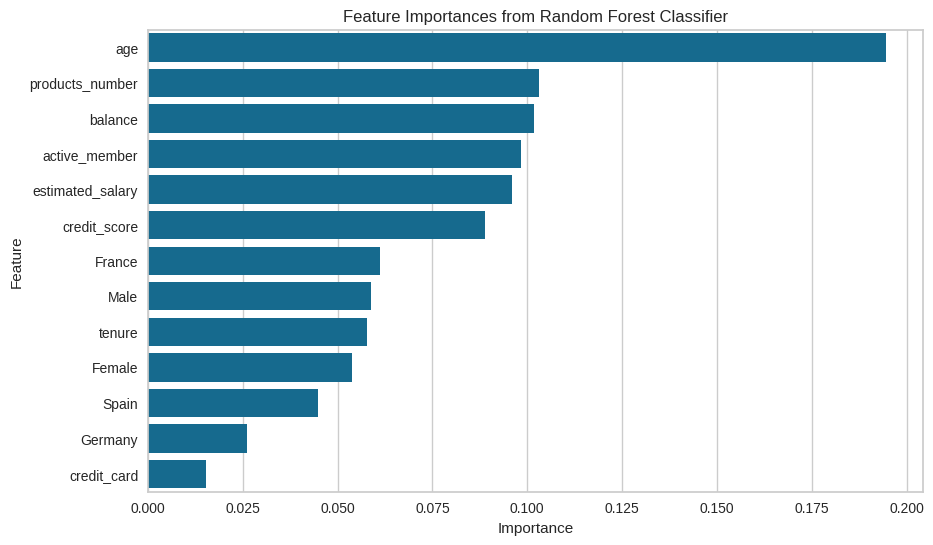

In [ ]:
# Initialize RandomForestClassifier
rdf = RandomForestClassifier(max_features = 3, n_estimators = 200, random_state=10)

# Fit the model
rdf.fit(X_train_smote, y_train_smote)

# Get feature importances
importances = rdf.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances from Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Yếu tố quan trọng nhất quyết định giữa khách hàng rời đi và khách hàng hiện tại là độ tuổi, theo sau đó là số sản phẩm sở hữu, số dư tài khoản và trạng thái hoạt động. Điều này hợp lý vì khách hàng lớn tuổi, có số dư cao nhưng ít tương tác (không hoạt động) có nhiều khả năng rời bỏ ngân hàng, ngay cả khi họ sở hữu nhiều sản phẩm.

Họ có thể đang tìm kiếm ngân hàng có lãi suất tốt hơn hoặc có kế hoạch rút tiền đầu tư nơi khác.

# Đề xuất:
Cải thiện mức độ tương tác với khách hàng lớn tuổi

Khuyến khích thành viên hoạt động tích cực

Xây dựng niềm tin và lòng trung thành

Giải quyết tình trạng rời bỏ của khách hàng có số dư cao

Triển khai chương trình dành riêng theo giới tính